Mounted at /content/drive


/tmp/ipython-input-1046824054.py:50: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'consumer-reviews-of-amazon-products' dataset.


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(
/tmp/ipython-input-1046824054.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["reviews"] = (df["reviews"].str.lower()
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authenticatio

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/27662 [00:00<?, ? examples/s]

Map:   0%|          | 0/6916 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1046824054.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,1.018900
200,0.854900
300,0.723100
400,0.620300
500,0.639000
600,0.567600
700,0.556500
800,0.634800
900,0.636300
1000,0.540000



*** Eval (key) ***
Saved adapter + tokenizer to: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Demo prediction: positive


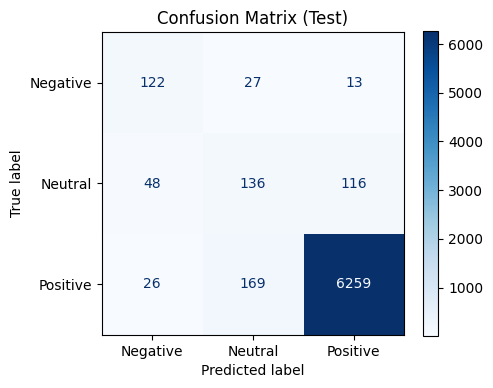

Saved: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/task1_test_predictions.csv
Saved: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/task1_test_predictions.json


In [ ]:
# =========================
# TASK 1: REVIEW CLASSIFICATION — MODULAR (WEB-APP READY)
# - Loads data from KaggleHub
# - Trains LoRA-based 3-class sentiment model
# - Exposes clean functions:
#     train_model(), load_model(), predict_review(), predict_reviews()
# - Saves predictions to CSV + JSON for downstream tasks
# =========================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, set_seed, DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

# ---- (Colab) Mount Drive for persistence
from google.colab import drive
drive.mount('/content/drive')

# ---- Global config
SAVE_DIR = "/content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project"
BASE_CKPT = "nlptown/bert-base-multilingual-uncased-sentiment"
DATASET_ID = "datafiniti/consumer-reviews-of-amazon-products"
DATA_KAGGLE_PATH = "1429_1.csv"   # file inside Kaggle dataset
os.makedirs(SAVE_DIR, exist_ok=True)

ID2LABEL = {0: "negative", 1: "neutral", 2: "positive"}
LABEL2ID = {"negative": 0, "neutral": 1, "positive": 2}


# ===== Data loading & preprocessing =====

def load_dataset_kagglehub(dataset_id=DATASET_ID, file_path=DATA_KAGGLE_PATH) -> pd.DataFrame:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        dataset_id,
        file_path,
    )
    return df

def clean_and_label(df: pd.DataFrame) -> pd.DataFrame:
    # Combine text + title, basic cleaning, drop short/dup
    df["reviews"] = df["reviews.text"].fillna("") + " " + df["reviews.title"].fillna("")
    df = df.dropna(subset=["reviews", "reviews.rating"])
    df["reviews"] = (df["reviews"].str.lower()
                                   .str.replace(r"\s+", " ", regex=True)
                                   .str.strip())
    df = df.drop_duplicates(subset=["reviews"])
    df = df[df["reviews"].str.split().str.len() > 3]

    # Map stars -> sentiment {1,2: neg; 3: neu; 4,5: pos}
    def map_sentiment(r):
        if r in [1, 2]: return 0
        if r == 3:      return 1
        return 2
    df["label"] = df["reviews.rating"].apply(map_sentiment)
    return df[["reviews", "label"]].reset_index(drop=True)

def make_splits(df: pd.DataFrame, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df, test_size=test_size, stratify=df["label"], random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

def to_hf_datasets(train_df: pd.DataFrame, test_df: pd.DataFrame, tokenizer, max_len=128):
    train_ds = Dataset.from_pandas(train_df)
    test_ds  = Dataset.from_pandas(test_df)

    def tokenize(batch):
        return tokenizer(batch["reviews"], truncation=True, padding="max_length", max_length=max_len)

    train_ds = train_ds.map(tokenize, batched=True, batch_size=512)
    test_ds  = test_ds.map(tokenize,  batched=True, batch_size=512)

    train_ds = train_ds.rename_column("label", "labels")
    test_ds  = test_ds.rename_column("label", "labels")
    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return train_ds, test_ds


# ===== Modeling (LoRA) =====

def build_lora_model(base_ckpt=BASE_CKPT):
    base_model = AutoModelForSequenceClassification.from_pretrained(
        base_ckpt,
        num_labels=3,
        id2label=ID2LABEL, label2id=LABEL2ID,
        ignore_mismatched_sizes=True
    )
    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["query", "value"],
    )
    model = get_peft_model(base_model, lora_cfg)
    return model

def class_weights_from_train(train_df: pd.DataFrame) -> torch.Tensor:
    counts = np.bincount(train_df["label"].to_numpy(), minlength=3)
    N, K = len(train_df), 3
    weights = N / (K * np.clip(counts, 1, None))
    return torch.tensor(weights, dtype=torch.float)

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    p_all, r_all, f1_all, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0,1,2], zero_division=0)
    return {
        "accuracy": acc,
        "precision_macro": p_macro, "recall_macro": r_macro, "f1_macro": f1_macro,
        "precision_weighted": p_w, "recall_weighted": r_w, "f1_weighted": f1_w,
        "precision_neg": p_all[0], "recall_neg": r_all[0], "f1_neg": f1_all[0],
        "precision_neu": p_all[1], "recall_neu": r_all[1], "f1_neu": f1_all[1],
        "precision_pos": p_all[2], "recall_pos": r_all[2], "f1_pos": f1_all[2],
    }


# ===== Public API =====

def train_model(
    save_dir: str = SAVE_DIR,
    base_ckpt: str = BASE_CKPT,
    num_epochs: int = 3,
    lr: float = 2e-5,
    seed: int = 42,
):
    """Train and save a LoRA sentiment model. Returns: (eval_metrics, test_df_path)"""
    set_seed(seed)

    # 1) Data
    df_raw = load_dataset_kagglehub(DATASET_ID, DATA_KAGGLE_PATH)
    df = clean_and_label(df_raw)
    train_df, test_df = make_splits(df, test_size=0.2, seed=seed)

    # 2) Tokenizer + HF datasets
    tokenizer = AutoTokenizer.from_pretrained(base_ckpt)
    data_collator = DataCollatorWithPadding(tokenizer, padding="longest")
    train_ds, test_ds = to_hf_datasets(train_df, test_df, tokenizer, max_len=128)

    # 3) Model + class weights
    model = build_lora_model(base_ckpt)
    class_weights = class_weights_from_train(train_df)

    # 4) Trainer
    args = TrainingArguments(
        output_dir=os.path.join(save_dir, "outputs-bert-lora-3class"),
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        logging_steps=100,
        save_steps=500,
        fp16=torch.cuda.is_available(),
        report_to=[]  # no wandb by default
    )

    trainer = WeightedTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        class_weights=class_weights,
    )

    # 5) Train + evaluate
    trainer.train()
    eval_metrics = trainer.evaluate(test_ds)

    # Pretty print minimal summary
    print("\n*** Eval (key) ***")
    for k in ["accuracy", "f1_macro", "precision_macro", "recall_macro"]:
        if k in eval_metrics:
            print(f"{k}: {eval_metrics[k]:.4f}")

    # 6) Save adapter + tokenizer for web-app inference
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"Saved adapter + tokenizer to: {save_dir}")

    # 7) Also return test_df so caller can create demo predictions
    test_df_path = os.path.join(save_dir, "task1_test_df.parquet")
    test_df.to_parquet(test_df_path, index=False)

    return eval_metrics, test_df_path


def load_model(model_dir: str = SAVE_DIR):
    """Load base model + LoRA adapter for inference."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    base = AutoModelForSequenceClassification.from_pretrained(
        BASE_CKPT, num_labels=3, ignore_mismatched_sizes=True
    )
    model = PeftModel.from_pretrained(base, model_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model.eval().to(device)
    return model, tokenizer, device


def predict_review(text: str, model, tokenizer, device, max_len=128) -> str:
    """Predict a single review string -> 'negative'|'neutral'|'positive'."""
    enc = tokenizer([text], truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    pred_id = int(logits.argmax(dim=-1).cpu().item())
    return ID2LABEL[pred_id]


def predict_reviews(texts, model, tokenizer, device, batch_size=64, max_len=128):
    """Predict a list of review strings."""
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
        pred_ids = logits.argmax(dim=-1).cpu().numpy().tolist()
        preds.extend([ID2LABEL[p] for p in pred_ids])
    return preds


def save_predictions(outputs_df: pd.DataFrame, save_dir: str = SAVE_DIR, basename: str = "test_predictions"):
    """Save predictions to CSV + JSON for downstream tasks."""
    csv_path = os.path.join(save_dir, f"{basename}.csv")
    json_path = os.path.join(save_dir, f"{basename}.json")

    outputs_df.to_csv(csv_path, index=False)

    # JSON structure: list of dicts (easy to consume by web/app or next tasks)
    records = outputs_df.to_dict(orient="records")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(records, f, ensure_ascii=False, indent=2)

    print(f"Saved: {csv_path}")
    print(f"Saved: {json_path}")
    return csv_path, json_path


# ===== Optional: demo runner (train, evaluate, predict on test, save outputs) =====

if __name__ == "__main__":
    # 1) Train once and persist artifacts
    eval_metrics, test_df_path = train_model()

    # 2) Load artifacts for inference (as the web app would)
    model, tokenizer, device = load_model(SAVE_DIR)

    # 3) Make a quick demo prediction
    demo_text = "I love this product, works perfectly and battery life is great!"
    print("\nDemo prediction:", predict_review(demo_text, model, tokenizer, device))

    # 4) Batch-predict on held-out test set and save CSV + JSON for later tasks
    test_df = pd.read_parquet(test_df_path)
    preds = predict_reviews(test_df["reviews"].tolist(), model, tokenizer, device)
    out_df = pd.DataFrame({
        "reviews": test_df["reviews"],
        "true_label": [ID2LABEL[i] for i in test_df["label"].tolist()],
        "pred_label": preds
    })

    # Minimal confusion matrix (optional plot for your report)
    y_true = test_df["label"].to_numpy()
    y_pred = np.array([LABEL2ID[p] for p in preds])
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, labels=[0,1,2], display_labels=["Negative","Neutral","Positive"], cmap="Blues", ax=ax
    )
    plt.title("Confusion Matrix (Test)"); plt.tight_layout(); plt.show()

    # Save predictions for downstream clustering/summarization
    save_predictions(out_df, SAVE_DIR, basename="task1_test_predictions")


In [ ]:
# =========================
# TASK 2: PRODUCT CATEGORY CLUSTERING (Colab-ready, integrates with Task 1 & sets up Task 3)
# - Loads the same dataset via KaggleHub (no re-upload needed)
# - Builds a product table (product_id, name, categories)
# - TF-IDF vectorizes product text and clusters with KMeans (k in {4,5,6}, auto-picked by silhouette)
# - Auto-generates human-readable cluster summaries from top TF-IDF terms
# - Assigns a meta-category (cluster) to every review
# - Optionally merges Task 1 sentiments (if task1_test_predictions.csv/json is present)
# - Saves artifacts for the web app and Task 3
# =========================

import os, json, re, ast, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

# ---- (Colab) Mount Drive for persistence
from google.colab import drive
drive.mount('/content/drive')

# ---- Global config (reuse same folder as Task 1)
SAVE_DIR = "/content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project"
DATASET_ID = "datafiniti/consumer-reviews-of-amazon-products"
DATA_KAGGLE_PATH = "1429_1.csv"   # file inside Kaggle dataset
os.makedirs(SAVE_DIR, exist_ok=True)

# If you saved Task 1 predictions with this name (from the modular script), we'll merge them in
TASK1_PRED_BASENAME = "task1_test_predictions"   # without extensions
TASK1_PRED_CSV = os.path.join(SAVE_DIR, f"{TASK1_PRED_BASENAME}.csv")
TASK1_PRED_JSON = os.path.join(SAVE_DIR, f"{TASK1_PRED_BASENAME}.json")

# -----------------------------
# 1) Load dataset (KaggleHub)
# -----------------------------
def load_dataset_kagglehub(dataset_id=DATASET_ID, file_path=DATA_KAGGLE_PATH) -> pd.DataFrame:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        dataset_id,
        file_path,
    )
    return df

# -----------------------------
# 2) Build product table
# -----------------------------
def _asins_first_token(x):
    """
    Convert the 'asins' column to a single stable ID (first ASIN if list-like).
    Handles formats like '["B00..."]', 'B00...', or NaN.
    """
    if pd.isna(x):
        return None
    # If it's a Python-list-like string, try to parse
    if isinstance(x, str) and (x.strip().startswith("[") and x.strip().endswith("]")):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, (list, tuple)) and len(parsed) > 0:
                return str(parsed[0])
        except Exception:
            pass
    # If it's already a string like "B00ABC..."
    return str(x).strip() if str(x).strip() != "" else None

def build_product_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a product-level table with:
      product_id, product_name, categories_text
    We try asins -> id -> name as product_id fallback.
    """
    # Try to gather source columns robustly
    cand_cols = df.columns.str.lower().tolist()

    def pick(colname_options, default=None):
        for c in colname_options:
            # match regardless of case
            hits = [col for col in df.columns if col.lower() == c.lower()]
            if hits:
                return hits[0]
        return default

    col_asins     = pick(["asins"])
    col_id        = pick(["id","sourceURLs","sourceid"]) or "id"
    col_name      = pick(["name","product_name"]) or "name"
    col_cats      = pick(["categories","primaryCategories"]) or "categories"

    # Safe get with defaults
    asins_series = df[col_asins] if col_asins in df.columns else pd.Series([None]*len(df))
    pid_asins = asins_series.apply(_asins_first_token)

    # fallbacks for missing product_id, If ASIN missing, fallback to another id; if still missing, fallback to product name (last resort).
    pid = pid_asins.fillna(df[col_id] if col_id in df.columns else None)
    if pid.isna().all():
        pid = df[col_name] if col_name in df.columns else pd.Series(range(len(df)), name="rowidx")

    # product name
    pname = df[col_name] if col_name in df.columns else pd.Series([""]*len(df), name="name")

    # categories text (may be list-like string; normalize to plain text)
    def _to_text(x):
        if pd.isna(x):
            return ""
        s = str(x)
        # strip brackets if looks like a list
        if s.strip().startswith("[") and s.strip().endswith("]"):
            try:
                arr = ast.literal_eval(s)
                if isinstance(arr, (list, tuple)):
                    return " / ".join([str(z) for z in arr if str(z).strip() != ""])
            except Exception:
                pass
        return s

    cats = df[col_cats].apply(_to_text) if col_cats in df.columns else pd.Series([""]*len(df), name="categories")

    prod = pd.DataFrame({
        "product_id": pid.astype(str),
        "product_name": pname.fillna("").astype(str),
        "categories_text": cats.fillna("").astype(str),
    })

    # drop rows with missing product_id
    prod = prod[prod["product_id"].notna() & (prod["product_id"].str.strip() != "")]
    # deduplicate to get product-level
    prod = prod.drop_duplicates(subset=["product_id"]).reset_index(drop=True)

    # a compact text field for vectorization
    prod["product_text"] = (prod["product_name"].fillna("") + " " + prod["categories_text"].fillna("")).str.lower()
    prod["product_text"] = prod["product_text"].str.replace(r"\s+", " ", regex=True).str.strip()

    return prod

# -----------------------------
# 3) Vectorize with TF-IDF
# -----------------------------
def tfidf_vectorize(texts, max_features=20000, ngram_range=(1,2), min_df=2):
    """
    Returns: (X, vectorizer)
      X: TF-IDF matrix (l2-normalized)
      vectorizer: fitted TfidfVectorizer
    """
    vec = TfidfVectorizer(
        max_features=max_features,     # limit vocabulary size for speed/memory.
        ngram_range=ngram_range,
        min_df=min_df,      # ignore terms that appear only once (too rare).
        strip_accents="unicode",
        lowercase=True
    )
    X = vec.fit_transform(texts)
    # cosine distance == euclidean on l2-normalized vectors; normalize helps k-means stability
    X = normalize(X, norm="l2", axis=1)
    return X, vec

# -----------------------------
# 4) Auto-pick K (4..6) by silhouette
# -----------------------------
def pick_best_k(X, ks=(4,5,6), random_state=42, n_init="auto", max_iter=300, sample_for_score=20000):
    """
    Tries k in ks and picks the best by silhouette score (on a sample if needed).
    Returns: (best_k, scores_dict, kmodels_dict)
    """
    from sklearn.utils import shuffle as sk_shuffle
    # sampling for silhouette if huge
    X_for_score = X
    if X.shape[0] > sample_for_score:
        idx = np.random.RandomState(42).choice(X.shape[0], size=sample_for_score, replace=False)
        X_for_score = X[idx]

    scores = {}
    models = {}
    for k in ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init, max_iter=max_iter)
        km.fit(X)
        # silhouette on sample to keep fast; use labels from full fit on sample rows
        if X_for_score is X:
            labels_for_score = km.labels_
        else:
            # predict cluster for sampled rows
            # scikit's KMeans doesn't have predict for sparse by default until newer versions;
            # we'll recompute distances via transform on sample:
            dist = km.transform(X_for_score)
            labels_for_score = dist.argmin(axis=1)
        try:
            score = silhouette_score(X_for_score, labels_for_score, metric="euclidean")
        except Exception:
            score = np.nan
        scores[k] = score
        models[k] = km

    # choose best (fallback to inertia if all NaN)
    if all(np.isnan(list(scores.values()))):
        # choose smallest inertia
        inertias = {k: models[k].inertia_ for k in ks}
        best_k = min(inertias, key=inertias.get)
    else:
        best_k = max(scores, key=lambda k: (scores[k] if not np.isnan(scores[k]) else -1e9))
    return best_k, scores, models

# -----------------------------
# 5) Extract top terms per cluster (for naming)
# -----------------------------
def top_terms_per_cluster(km: KMeans, vec: TfidfVectorizer, topn=12):
    """
    Returns dict: cluster_id -> list of top terms (by centroid weights).
    """
    terms = np.array(vec.get_feature_names_out())
    centers = km.cluster_centers_
    out = {}
    for cid in range(km.n_clusters):
        weights = centers[cid]
        top_idx = np.argsort(weights)[::-1][:topn]
        out[cid] = terms[top_idx].tolist()
    return out

def auto_label_from_terms(terms_list):
    """
    Simple heuristic to compress terms into a readable label suggestion.
    """
    # prioritize some common electronics keywords (you can expand this list)
    KEYWORDS = [
        "ebook", "reader", "kindle", "kobo", "paperwhite",
        "battery", "rechargeable", "aa", "aaa", "charger",
        "keyboard", "mouse", "laptop", "stand", "usb", "cable", "case",
        "headphones", "earbuds", "speakers",
        "nespresso", "pods", "coffee",
        "pet", "carrier", "cat", "dog",
        "non", "electronics", "accessory", "accessories"
    ]
    picked = [t for t in terms_list if t in KEYWORDS]
    label = " / ".join(picked[:3]) if picked else "Misc"
    # small prettify
    label = label.replace("/", " / ").title()
    return label if label else "Misc"

# -----------------------------
# 6) Assign clusters to products & reviews
# -----------------------------
def assign_product_clusters(prod_df, X, km, cluster_names=None):
    labels = km.labels_
    prod_df = prod_df.copy()
    prod_df["cluster_id"] = labels

    # if no manual names provided, auto-generate
    if cluster_names is None:
        cluster_names = {}
        # build from top terms
        # we'll fill after we compute them in the main pipeline
    prod_df["cluster_label"] = prod_df["cluster_id"].map(lambda x: cluster_names.get(x, f"Cluster {x}"))
    return prod_df

def build_reviews_with_categories(df_raw, products_with_clusters):
    """
    Returns a review-level dataframe with cluster info merged in.
    Tries to use product_id; if not possible, falls back to product name matching.
    """
    # replicate the product_id logic to merge
    # (must match build_product_table)
    pid_series = df_raw.get("asins")
    if pid_series is not None:
        pid_series = df_raw["asins"].apply(_asins_first_token)
    else:
        pid_series = None

    if pid_series is None or pid_series.isna().all():
        pid_series = df_raw.get("id")
        if pid_series is None or pid_series.isna().all():
            pid_series = df_raw.get("name")
    df_reviews = pd.DataFrame({
        "product_id": pid_series.astype(str),
        "product_name": df_raw.get("name", pd.Series([""]*len(df_raw))).astype(str),
        "reviews": (df_raw.get("reviews.text", pd.Series([""]*len(df_raw))).fillna("") + " " +
                    df_raw.get("reviews.title", pd.Series([""]*len(df_raw))).fillna("")).str.lower().str.replace(r"\s+"," ",regex=True).str.strip(),
        "reviews.rating": df_raw.get("reviews.rating", np.nan)
    })
    df_reviews = df_reviews[df_reviews["reviews"].str.len() > 0]
    df_reviews = df_reviews.drop_duplicates(subset=["reviews"]).reset_index(drop=True)

    out = df_reviews.merge(
        products_with_clusters[["product_id", "cluster_id", "cluster_label"]],
        on="product_id", how="left"
    )
    return out

# -----------------------------
# 7) Optional: merge Task 1 sentiment predictions (if available)
# -----------------------------
def maybe_merge_task1_sentiment(reviews_df: pd.DataFrame) -> pd.DataFrame:
    merged = reviews_df.copy()
    task1_df = None
    if os.path.exists(TASK1_PRED_CSV):
        try:
            task1_df = pd.read_csv(TASK1_PRED_CSV)
        except Exception:
            task1_df = None
    elif os.path.exists(TASK1_PRED_JSON):
        try:
            task1_df = pd.read_json(TASK1_PRED_JSON)
        except Exception:
            task1_df = None

    if task1_df is not None and "reviews" in task1_df.columns:
        # normalize text to lower/strip to align with our cleaning
        task1_df = task1_df.copy()
        task1_df["reviews"] = task1_df["reviews"].astype(str).str.lower().str.replace(r"\s+"," ",regex=True).str.strip()
        # expected columns: reviews, pred_label (from Task 1 script)
        pred_col = "pred_label" if "pred_label" in task1_df.columns else None
        if pred_col:
            merged = merged.merge(
                task1_df[["reviews", pred_col]].drop_duplicates("reviews"),
                on="reviews", how="left"
            )
            merged.rename(columns={pred_col: "sentiment_pred"}, inplace=True)
    return merged

# -----------------------------
# 8) Save artifacts
# -----------------------------
def save_artifacts(products_with_clusters,
                   reviews_with_category,
                   vec: TfidfVectorizer,
                   kmeans: KMeans,
                   cluster_terms: dict,
                   cluster_name_map: dict,
                   out_dir=SAVE_DIR):
    os.makedirs(out_dir, exist_ok=True)

    # a) product-level clustering table
    prod_path = os.path.join(out_dir, "products_with_clusters.parquet")
    products_with_clusters.to_parquet(prod_path, index=False)

    # b) review-level with categories (+ optional sentiment)
    rev_path = os.path.join(out_dir, "reviews_with_sentiment_and_category.parquet")
    reviews_with_category.to_parquet(rev_path, index=False)

    # c) product_id -> cluster map (JSON)
    cmap = {
        pid: {"cluster_id": int(cid), "cluster_label": str(clabel)}
        for pid, cid, clabel in products_with_clusters[["product_id","cluster_id","cluster_label"]].itertuples(index=False, name=None)
    }
    cmap_path = os.path.join(out_dir, "category_map.json")
    with open(cmap_path, "w", encoding="utf-8") as f:
        json.dump(cmap, f, ensure_ascii=False, indent=2)

    # d) vectorizer + kmeans params (JSON; lightweight & portable)
    # (If you prefer, pickle objects, but JSON captures enough to rebuild)
    vec_info = {
        "max_features": vec.max_features,
        "ngram_range": vec.ngram_range,
        "min_df": vec.min_df,
        "vocab_size": int(len(vec.get_feature_names_out()))
    }
    km_info = {
        "n_clusters": int(kmeans.n_clusters),
        "random_state": getattr(kmeans, "random_state", None),
        "inertia": float(kmeans.inertia_)
    }
    meta = {
        "vectorizer": vec_info,
        "kmeans": km_info,
        "cluster_top_terms": cluster_terms,
        "cluster_name_map": {int(k): v for k, v in cluster_name_map.items()}
    }
    meta_path = os.path.join(out_dir, "clustering_metadata.json")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    print(f"Saved:\n- {prod_path}\n- {rev_path}\n- {cmap_path}\n- {meta_path}")
    return {"products": prod_path, "reviews": rev_path, "map": cmap_path, "meta": meta_path}

# -----------------------------
# 9) Main pipeline
# -----------------------------
def run_task2_pipeline():
    # Load raw
    df_raw = load_dataset_kagglehub(DATASET_ID, DATA_KAGGLE_PATH)

    # Products
    products = build_product_table(df_raw)
    print(f"Products detected: {len(products):,}")

    # Vectorize
    X, vec = tfidf_vectorize(products["product_text"].tolist(),
                             max_features=20000, ngram_range=(1,2), min_df=2)

    # Auto-pick k in {4,5,6}
    best_k, scores, models = pick_best_k(X, ks=(4,5,6))
    km = models[best_k]
    print("Silhouette scores (NaN means not computed):", scores)
    print(f"Chosen k = {best_k}  | inertia = {km.inertia_:.2f}")

    # Cluster & label
    products_with_clusters = assign_product_clusters(products, X, km, cluster_names=None)
    # Build top terms for human naming
    cluster_terms = top_terms_per_cluster(km, vec, topn=12)
    # Auto-name clusters from terms (you can later replace these strings manually)
    name_map = {}
    for cid, terms in cluster_terms.items():
        name_map[cid] = auto_label_from_terms(terms)

    products_with_clusters["cluster_label"] = products_with_clusters["cluster_id"].map(lambda x: name_map.get(x, f"Cluster {x}"))

    # Reviews with categories
    reviews_with_category = build_reviews_with_categories(df_raw, products_with_clusters)

    # Optional: bring in Task 1 predictions if present
    reviews_with_category = maybe_merge_task1_sentiment(reviews_with_category)

    # Save artifacts
    paths = save_artifacts(products_with_clusters, reviews_with_category, vec, km, cluster_terms, name_map, out_dir=SAVE_DIR)

    # Print a tiny preview
    print("\n=== Preview: products_with_clusters ===")
    display(products_with_clusters.head(8))

    print("\n=== Preview: reviews_with_sentiment_and_category ===")
    display(reviews_with_category.head(8))

    # Also show a concise cluster summary
    print("\n=== Cluster Name Suggestions (from top terms) ===")
    for cid in sorted(cluster_terms.keys()):
        print(f"[{cid}] {name_map[cid]}  |  terms: {', '.join(cluster_terms[cid][:10])}")

    return paths, {"best_k": best_k, "scores": scores}

# -----------------------------
# 10) Run
# -----------------------------
if __name__ == "__main__":
    paths, info = run_task2_pipeline()
    print("\nArtifacts saved to:", SAVE_DIR)
    print("Best k:", info["best_k"])


Mounted at /content/drive
Using Colab cache for faster access to the 'consumer-reviews-of-amazon-products' dataset.
Products detected: 42
Silhouette scores (NaN means not computed): {4: np.float64(0.11861798893435108), 5: np.float64(0.11264689528392824), 6: np.float64(0.12476989063427765)}
Chosen k = 6  | inertia = 21.01
Saved:
- /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/products_with_clusters.parquet
- /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/reviews_with_sentiment_and_category.parquet
- /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/category_map.json
- /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/clustering_metadata.json

=== Preview: products_with_clusters ===


,product_id,product_name,categories_text,product_text,cluster_id,cluster_label
0,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...","all-new fire hd 8 tablet, 8 hd display, wi-fi,...",2,Misc
1,B00VINDBJK,Kindle Oasis E-reader with Leather Charging Co...,"eBook Readers,Kindle E-readers,Computers & Tab...",kindle oasis e-reader with leather charging co...,4,Kindle
2,B005PB2T0S,"Amazon Kindle Lighted Leather Cover,,,\r\nAmaz...","Electronics,eBook Readers & Accessories,Covers...","amazon kindle lighted leather cover,,, amazon ...",1,Accessories / Kindle
3,B002Y27P3M,"Kindle Keyboard,,,\r\nKindle Keyboard,,,","Kindle Store,Amazon Devices,Electronics","kindle keyboard,,, kindle keyboard,,, kindle s...",1,Accessories / Kindle
4,B01AHB9CYG,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Tablets,Fire Tablets,Electronics,Computers,Com...","all-new fire hd 8 tablet, 8 hd display, wi-fi,...",2,Misc
5,B01AHB9C1E,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 ...","Tablets,Fire Tablets,Computers & Tablets,All T...","fire hd 8 tablet with alexa, 8 hd display, 32 ...",2,Misc
6,B01J2G4VBG,Amazon 5W USB Official OEM Charger and Power A...,"Amazon Devices & Accessories,Amazon Device Acc...",amazon 5w usb official oem charger and power a...,1,Accessories / Kindle
7,B00ZV9PXP2,"Amazon Kindle Fire Hd (3rd Generation) 8gb,,,\...","Electronics,iPad & Tablets,All Tablets,Compute...","amazon kindle fire hd (3rd generation) 8gb,,, ...",0,Kindle



=== Preview: reviews_with_sentiment_and_category ===


,product_id,product_name,reviews,reviews.rating,cluster_id,cluster_label,sentiment_pred
0,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",this product so far has not disappointed. my c...,5.0,2.0,Misc,NaN
1,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",great for beginner or experienced person. boug...,5.0,2.0,Misc,positive
2,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",inexpensive tablet for him to use and learn on...,5.0,2.0,Misc,NaN
3,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",i've had my fire hd 8 two weeks now and i love...,4.0,2.0,Misc,NaN
4,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",i bought this for my grand daughter when she c...,5.0,2.0,Misc,NaN
5,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",this amazon fire 8 inch tablet is the perfect ...,5.0,2.0,Misc,NaN
6,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","great for e-reading on the go, nice and light ...",4.0,2.0,Misc,NaN
7,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","i gave this as a christmas gift to my inlaws, ...",5.0,2.0,Misc,NaN



=== Cluster Name Suggestions (from top terms) ===
[0] Kindle  |  terms: tablets, readers, computers, amazon kindle, computers tablets, kindle fire, kindle, brand new, blue, display tablet
[1] Accessories  /  Kindle  |  terms: accessories, kindle, cables, power, accessories kindle, amazon, adapters, store, kindle store, power adapters
[2] Misc  |  terms: tablets, hd, hd display, hd tablet, tablets fire, fire hd, all, fire, with, 32 gb
[3] Speakers  /  Electronics  |  terms: home, smart, echo, speakers, white, echo white, smart home, audio, streaming, electronics
[4] Kindle  |  terms: readers, kindle, 300, ppi, 300 ppi, display 300, high resolution, resolution, resolution display, high
[5] Misc  |  terms: tablets, fire, tablet display, fi gb, display wi, gb includes, fire tablet, wi, fi, wi fi

Artifacts saved to: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project
Best k: 6


## TASK 3: REVIEW SUMMARIZATION USING GENERATIVE AI

In [ ]:
# =========================
# TASK 3: REVIEW SUMMARIZATION USING GENERATIVE AI
# - Loads Task 2 artifacts
# - Builds structured "evidence bundles" per meta-category
# - Uses a pretrained generative model (BART/T5) to write blog-style articles
# - Saves per-category evidence (.json) and article (.md) + an index
# =========================

import os, json, re, math, string
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import minmax_scale

# Colab: mount Drive to persist outputs
from google.colab import drive
drive.mount('/content/drive')

# -------- Config --------
SAVE_DIR = "/content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project"
ARTICLES_DIR = os.path.join(SAVE_DIR, "task3_summaries")
os.makedirs(ARTICLES_DIR, exist_ok=True)

REVIEWS_PARQUET = os.path.join(SAVE_DIR, "reviews_with_sentiment_and_category.parquet")
PRODUCTS_PARQUET = os.path.join(SAVE_DIR, "products_with_clusters.parquet")

# Choose a summarization model: BART (good quality) or T5 (smaller/faster)
GEN_MODEL_NAME = "facebook/bart-large-cnn"  # or "t5-small"

# -------- Load Gen Model --------
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda" if torch.cuda.is_available() else "cpu"
gen_tokenizer = AutoTokenizer.from_pretrained(GEN_MODEL_NAME)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(GEN_MODEL_NAME).to(device).eval()

# -------- Helpers: text cleaning & keyphrase mining --------

PUNCT_TABLE = str.maketrans({p: " " for p in string.punctuation})
STOP = set(ENGLISH_STOP_WORDS) | {
    # domain filler words you may want to ignore
    "amazon","product","item","buy","bought","purchase","purchased","use","used","using",
    "get","got","make","made","one","also","would","could","still","really","review","reviews"
}

def normalize_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower().translate(PUNCT_TABLE)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def ngram_phrases(texts, ngram_range=(1,3), top_k=20, extra_stop=()):
    """
    Return top n-gram phrases by TF-IDF score across the given texts.
    """
    stop = STOP | set(extra_stop)
    vec = TfidfVectorizer(
        ngram_range=ngram_range,
        min_df=2,
        stop_words=stop,
        strip_accents="unicode",
        lowercase=True
    )
    try:
        X = vec.fit_transform(texts)
    except ValueError:
        return []  # not enough text
    terms = np.array(vec.get_feature_names_out())
    scores = np.asarray(X.sum(axis=0)).ravel()
    top_idx = np.argsort(scores)[::-1][:top_k]
    return [terms[i] for i in top_idx]

# -------- Load artifacts from Task 2 --------

def load_task2_frames():
    reviews = pd.read_parquet(REVIEWS_PARQUET)
    products = pd.read_parquet(PRODUCTS_PARQUET)
    # normalize text to be safe
    reviews["reviews"] = reviews["reviews"].astype(str).apply(normalize_text)
    # sentiment_pred might be missing if you didn't merge it in Task 2; handle gracefully
    if "sentiment_pred" not in reviews.columns:
        # fallback from ratings if needed
        def rate_to_sent(r):
            try:
                r = float(r)
            except:
                return "neutral"
            if r <= 2: return "negative"
            if r == 3: return "neutral"
            return "positive"
        reviews["sentiment_pred"] = reviews.get("reviews.rating", np.nan).apply(rate_to_sent)
    return reviews, products

# -------- Build product-level stats per category --------

def product_stats_in_category(reviews_cat: pd.DataFrame):
    """
    Returns a dataframe with per-product aggregates within a category:
      product_id, product_name, num_reviews, avg_star, pos_ratio, neg_ratio
    """
    # fallback for avg_star if missing
    if "reviews.rating" in reviews_cat.columns:
        avg_star = reviews_cat.groupby("product_id")["reviews.rating"].mean().rename("avg_star")
    else:
        # if no numeric stars, approximate from sentiment
        star_map = {"positive": 4.5, "neutral": 3.0, "negative": 1.5}
        avg_star = reviews_cat.groupby("product_id")["sentiment_pred"].apply(
            lambda s: np.mean([star_map.get(x, 3.0) for x in s])
        ).rename("avg_star")

    size = reviews_cat.groupby("product_id")["reviews"].size().rename("num_reviews")

    # sentiment ratios
    val_counts = reviews_cat.groupby(["product_id","sentiment_pred"])["reviews"].size().unstack(fill_value=0)
    for c in ["positive","neutral","negative"]:
        if c not in val_counts.columns: val_counts[c] = 0
    total = val_counts.sum(axis=1).replace(0, 1)  # avoid div by zero
    pos_ratio = (val_counts["positive"] / total).rename("pos_ratio")
    neg_ratio = (val_counts["negative"] / total).rename("neg_ratio")

    names = reviews_cat.groupby("product_id")["product_name"].agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else "").rename("product_name")

    dfp = pd.concat([names, size, avg_star, pos_ratio, neg_ratio], axis=1).reset_index()
    return dfp

def score_products(dfp: pd.DataFrame):
    """
    Simple blended score to rank products:
      - normalize avg_star to 0..1
      - log-scale review counts
      - incorporate pos_ratio
    """
    if len(dfp) == 0:
        return dfp.assign(score=[])
    df = dfp.copy()
    df["avg_star_norm"] = minmax_scale(df["avg_star"])
    df["log_reviews"] = np.log1p(df["num_reviews"])
    if df["log_reviews"].max() > 0:
        df["log_reviews"] = df["log_reviews"] / df["log_reviews"].max()
    df["score"] = 0.5*df["avg_star_norm"] + 0.3*df["pos_ratio"] + 0.2*df["log_reviews"]
    return df

# -------- Extract pros & complaints per product --------

def product_keyphrases(reviews_cat: pd.DataFrame, product_id: str, top_k=6, brand_words=()):
    sub = reviews_cat[reviews_cat["product_id"] == product_id]
    pos_texts = sub.loc[sub["sentiment_pred"]=="positive","reviews"].tolist()
    neg_texts = sub.loc[sub["sentiment_pred"]=="negative","reviews"].tolist()
    pros = ngram_phrases(pos_texts, top_k=top_k, extra_stop=brand_words)[:3]
    cons = ngram_phrases(neg_texts, top_k=top_k, extra_stop=brand_words)[:3]
    return pros, cons

# -------- Differences among Top 3 --------

def differences_among(top3_info):
    """
    Given top3 list of dicts with 'name' and 'pros',
    return simple difference bullets highlighting unique pros.
    """
    diffs = []
    names = [p["name"] for p in top3_info]
    pros_lists = [set(p.get("pros", [])) for p in top3_info]
    for i, (name, pros) in enumerate(zip(names, pros_lists)):
        others = set().union(*[pros_lists[j] for j in range(len(pros_lists)) if j!=i])
        unique = list(pros - others)
        if unique:
            diffs.append(f"{name}: {', '.join(unique[:2])}")
    return diffs[:4] if diffs else []

# -------- Evidence bundle builder --------

def build_evidence_for_category(cat_name: str, reviews_all: pd.DataFrame):
    reviews_cat = reviews_all[reviews_all["cluster_label"] == cat_name].copy()
    if len(reviews_cat) < 10:
        return None  # too little data

    # Basic brand words to filter from phrases (from product names)
    brand_words = set()
    for nm in reviews_cat["product_name"].dropna().astype(str).tolist():
        for w in normalize_text(nm).split():
            if len(w) > 2: brand_words.add(w)

    stats = product_stats_in_category(reviews_cat)
    ranked = score_products(stats).sort_values("score", ascending=False)

    # choose top3 & worst (ensure worst has at least few reviews)
    top3 = ranked.head(3)
    worst = ranked[ranked["num_reviews"] >= max(3, int(ranked["num_reviews"].median()/2) or 1)].tail(1)
    worst = worst.iloc[0] if len(worst) else ranked.tail(1).iloc[0]

    # build top3 info
    top3_info = []
    for _, row in top3.iterrows():
        pid = row["product_id"]
        pros, cons = product_keyphrases(reviews_cat, pid, top_k=8, brand_words=brand_words)
        top3_info.append({
            "id": pid,
            "name": row["product_name"],
            "avg_star": float(row["avg_star"]),
            "num_reviews": int(row["num_reviews"]),
            "pos_ratio": float(row["pos_ratio"]),
            "neg_ratio": float(row["neg_ratio"]),
            "pros": pros,
            "complaints": cons
        })

    # worst info
    wpid = worst["product_id"]
    w_pros, w_cons = product_keyphrases(reviews_cat, wpid, top_k=8, brand_words=brand_words)
    worst_info = {
        "id": wpid,
        "name": worst["product_name"],
        "avg_star": float(worst["avg_star"]),
        "num_reviews": int(worst["num_reviews"]),
        "pos_ratio": float(worst["pos_ratio"]),
        "neg_ratio": float(worst["neg_ratio"]),
        "top_complaints": w_cons[:3]
    }

    diffs = differences_among(top3_info)

    evidence = {
        "category": cat_name,
        "top_products": top3_info,
        "differences": diffs,
        "worst_product": worst_info,
        "method_note": "Ranking = 0.5*normalized average star + 0.3*positive ratio + 0.2*log(review_count). Keyphrases via TF-IDF on positive/negative subsets."
    }
    return evidence

# -------- Prompting / article generation --------

def evidence_to_prompt(e):
    """
    Convert evidence dict to a compact, instruction-following prompt for the generator.
    Keep it short-ish to fit model context.
    """
    lines = []
    lines.append(f"Category: {e['category']}")
    lines.append("Write a concise, factual, blog-style recommendation article (~350-500 words).")
    lines.append("Sections required: Top 3 products (with key differences), Top complaints per product, Worst product and why to avoid. Use only the facts provided. Do not invent specs.")
    lines.append("")
    lines.append("Top 3 products:")
    for i, p in enumerate(e["top_products"], 1):
        lines.append(f"{i}. {p['name']} (avg_star={p['avg_star']:.2f}, reviews={p['num_reviews']}, pos_ratio={p['pos_ratio']:.2f})")
        if p["pros"]:
            lines.append(f"   Pros: {', '.join(p['pros'][:3])}")
        if p["complaints"]:
            lines.append(f"   Complaints: {', '.join(p['complaints'][:3])}")
    if e.get("differences"):
        lines.append("")
        lines.append("Key differences among top picks:")
        for d in e["differences"]:
            lines.append(f"- {d}")
    lines.append("")
    w = e["worst_product"]
    lines.append(f"Worst product: {w['name']} (avg_star={w['avg_star']:.2f}, reviews={w['num_reviews']})")
    if w.get("top_complaints"):
        lines.append(f"Top complaints: {', '.join(w['top_complaints'][:3])}")
    lines.append("")
    lines.append(f"Method note: {e['method_note']}")
    return "\n".join(lines)

def generate_article(prompt: str, max_new_tokens=450):
    inputs = gen_tokenizer([prompt], return_tensors="pt", truncation=True, max_length=1024).to(device)
    with torch.no_grad():
        outputs = gen_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            length_penalty=1.0,
            no_repeat_ngram_size=3,
            early_stopping=True
        )
    text = gen_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return text

# -------- Orchestration --------

def run_task3():
    reviews, products = load_task2_frames()
    categories = sorted(reviews["cluster_label"].dropna().unique().tolist())

    index_entries = []
    for cat in categories:
        evidence = build_evidence_for_category(cat, reviews)
        if evidence is None:
            print(f"Skip '{cat}' (not enough data).")
            continue

        prompt = evidence_to_prompt(evidence)
        article = generate_article(prompt, max_new_tokens=450)

        # Save evidence + article
        base = re.sub(r"[^a-z0-9]+", "_", cat.lower()).strip("_")
        ev_path = os.path.join(ARTICLES_DIR, f"{base}_evidence.json")
        md_path = os.path.join(ARTICLES_DIR, f"{base}_article.md")
        with open(ev_path, "w", encoding="utf-8") as f:
            json.dump(evidence, f, ensure_ascii=False, indent=2)
        with open(md_path, "w", encoding="utf-8") as f:
            f.write(f"# Best {cat}: Top Picks and One to Skip\n\n")
            f.write(article.strip() + "\n")

        print(f"Saved: {md_path}")
        index_entries.append({
            "category": cat,
            "evidence_path": ev_path,
            "article_path": md_path
        })

    # Save an index of all category summaries
    idx_path = os.path.join(ARTICLES_DIR, "category_summaries_index.json")
    with open(idx_path, "w", encoding="utf-8") as f:
        json.dump(index_entries, f, ensure_ascii=False, indent=2)
    print(f"\nIndex saved: {idx_path}")
    return idx_path

# ---- Run
if __name__ == "__main__":
    run_task3()


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Saved: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/task3_summaries/accessories_kindle_article.md
Saved: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/task3_summaries/kindle_article.md
Saved: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/task3_summaries/misc_article.md
Saved: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/task3_summaries/speakers_electronics_article.md

Index saved: /content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project/task3_summaries/category_summaries_index.json


In [ ]:
# app.py
# ============================================
# Marketing Insights Dashboard (Streamlit)
# - Task 1: Live sentiment classification (LoRA transformer)
# - Task 2: Category clustering insights (TF-IDF + KMeans artifacts)
# - Task 3: Category summaries (BART/T5-generated markdown)
# ============================================

import os, json, re, math, string
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import streamlit as st

# Optional plotting
import altair as alt

# ======= CONFIG (edit these defaults to your paths) =======
# If you're on Colab + Drive, point to your SAVE_DIR from earlier steps.
DEFAULT_ARTIFACTS_DIR = "/content/drive/MyDrive/Ironhack Assignments/LLM_Customer_review_project"
DEFAULT_SUMMARIES_DIR = os.path.join(DEFAULT_ARTIFACTS_DIR, "task3_summaries")
DEFAULT_MODEL_DIR = DEFAULT_ARTIFACTS_DIR  # where you saved LoRA adapter + tokenizer in Task 1

# ======= CACHING HELPERS =======
@st.cache_data(show_spinner=False)
def load_parquet(path: str) -> pd.DataFrame:
    return pd.read_parquet(path)

@st.cache_data(show_spinner=False)
def load_json(path: str) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

@st.cache_resource(show_spinner=False)
def load_sentiment_model(model_dir: str):
    """Load Task-1 LoRA model for live classification."""
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    from peft import PeftModel

    device = "cuda" if torch.cuda.is_available() else "cpu"
    BASE_CKPT = "nlptown/bert-base-multilingual-uncased-sentiment"

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    base = AutoModelForSequenceClassification.from_pretrained(
        BASE_CKPT, num_labels=3, ignore_mismatched_sizes=True
    )
    model = PeftModel.from_pretrained(base, model_dir)
    model.eval().to(device)

    id2label = {0: "negative", 1: "neutral", 2: "positive"}
    return model, tokenizer, device, id2label

def predict_label(text: str, model, tokenizer, device, max_len=128) -> str:
    import torch
    if not text.strip():
        return ""
    enc = tokenizer([text], truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    pred_id = int(logits.argmax(dim=-1).cpu().item())
    return {0:"negative",1:"neutral",2:"positive"}[pred_id]

# ======= UI LAYOUT =======
st.set_page_config(page_title="Marketing Insights Dashboard", layout="wide")

st.title("📊 Marketing Insights Dashboard")
st.caption("Sentiment Classification • Category Clustering • Generative Summaries")

with st.sidebar:
    st.header("Settings")
    artifacts_dir = st.text_input("Artifacts directory", DEFAULT_ARTIFACTS_DIR)
    summaries_dir = st.text_input("Summaries directory (Task 3)", DEFAULT_SUMMARIES_DIR)
    model_dir = st.text_input("Sentiment model dir (Task 1)", DEFAULT_MODEL_DIR)

    # Expected artifact paths
    products_path = os.path.join(artifacts_dir, "products_with_clusters.parquet")
    reviews_path = os.path.join(artifacts_dir, "reviews_with_sentiment_and_category.parquet")
    meta_path = os.path.join(artifacts_dir, "clustering_metadata.json")
    idx_path = os.path.join(summaries_dir, "category_summaries_index.json")

    st.markdown("**Expected files:**")
    st.code(f"{products_path}\n{reviews_path}\n{meta_path}\n{idx_path}", language="text")

# ======= LOAD DATA SAFELY =======
missing = []
if not os.path.exists(products_path): missing.append(products_path)
if not os.path.exists(reviews_path): missing.append(reviews_path)
if not os.path.exists(meta_path):     missing.append(meta_path)
if not os.path.exists(idx_path):      missing.append(idx_path)

if missing:
    st.error("Missing required files:\n" + "\n".join(missing))
    st.stop()

products_df = load_parquet(products_path)
reviews_df = load_parquet(reviews_path)
meta = load_json(meta_path)
summ_index = load_json(idx_path)

# Ensure required columns exist
if "cluster_label" not in products_df.columns or "cluster_label" not in reviews_df.columns:
    st.error("cluster_label not found. Please run Task 2 pipeline first.")
    st.stop()

# Prepare category list
categories = sorted([c for c in reviews_df["cluster_label"].dropna().unique().tolist() if str(c).strip() != ""])
if not categories:
    st.error("No categories found in reviews. Check Task 2 outputs.")
    st.stop()

# ======= TABS =======
tab_overview, tab_category, tab_classifier = st.tabs([
    "Overview", "Category Insights", "Live Classifier"
])

# ================= OVERVIEW =================
with tab_overview:
    st.subheader("Dataset Overview")
    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("Unique Products", f"{products_df['product_id'].nunique():,}")
    with col2:
        st.metric("Total Reviews", f"{len(reviews_df):,}")
    with col3:
        st.metric("Meta-Categories", f"{len(categories)}")

    # Category size chart
    cat_counts = reviews_df["cluster_label"].value_counts().reset_index()
    cat_counts.columns = ["category", "reviews"]
    chart = (
        alt.Chart(cat_counts)
        .mark_bar()
        .encode(x=alt.X("category:N", sort='-y'), y="reviews:Q", tooltip=["category","reviews"])
        .properties(height=300)
    )
    st.altair_chart(chart, use_container_width=True)

    # Show cluster name suggestions from meta
    st.markdown("### Cluster Name Suggestions (from top terms)")
    cluster_terms = meta.get("cluster_top_terms", {})
    cluster_name_map = meta.get("cluster_name_map", {})
    rows = []
    for cid_str, terms in cluster_terms.items():
        cid = int(cid_str) if isinstance(cid_str, str) and cid_str.isdigit() else cid_str
        rows.append({
            "cluster_id": cid,
            "label": cluster_name_map.get(str(cid), cluster_name_map.get(cid, f"Cluster {cid}")),
            "top_terms": ", ".join(terms[:10])
        })
    if rows:
        st.dataframe(pd.DataFrame(rows))

# ================= CATEGORY INSIGHTS =================
with tab_category:
    st.subheader("Category Insights & Summary")
    sel_cat = st.selectbox("Choose a category", categories, index=0)

    cat_reviews = reviews_df[reviews_df["cluster_label"] == sel_cat].copy()
    if cat_reviews.empty:
        st.warning("No reviews in this category.")
    else:
        # Sentiment distribution (from Task 1 merged or rating fallback)
        if "sentiment_pred" not in cat_reviews.columns:
            # fallback from rating if needed
            def rate_to_sent(r):
                try:
                    r = float(r)
                except:
                    return "neutral"
                if r <= 2: return "negative"
                if r == 3: return "neutral"
                return "positive"
            cat_reviews["sentiment_pred"] = cat_reviews.get("reviews.rating", np.nan).apply(rate_to_sent)

        colA, colB = st.columns(2)
        with colA:
            st.markdown("**Sentiment distribution**")
            sent_counts = cat_reviews["sentiment_pred"].value_counts().reindex(["negative","neutral","positive"]).fillna(0).astype(int).reset_index()
            sent_counts.columns = ["sentiment", "count"]
            sent_chart = (
                alt.Chart(sent_counts)
                .mark_bar()
                .encode(x=alt.X("sentiment:N", sort=["negative","neutral","positive"]),
                        y="count:Q", tooltip=["sentiment","count"])
                .properties(height=300)
            )
            st.altair_chart(sent_chart, use_container_width=True)

        with colB:
            st.markdown("**Top products by average rating**")
            if "reviews.rating" in cat_reviews.columns:
                top_ratings = (
                    cat_reviews.groupby(["product_id","product_name"])["reviews.rating"]
                    .mean().reset_index().sort_values("reviews.rating", ascending=False).head(10)
                )
                st.dataframe(top_ratings.rename(columns={"reviews.rating":"avg_rating"}))
            else:
                st.info("Numeric star ratings not available in this dataset slice.")

        # ===== Show generated article (Task 3) =====
        st.markdown("### 📝 Category Summary (Generated)")
        # Find article path from index
        def find_article_path(category: str) -> str:
            for row in summ_index:
                if row.get("category") == category:
                    return row.get("article_path", "")
            return ""
        md_path = find_article_path(sel_cat)
        if md_path and os.path.exists(md_path):
            with open(md_path, "r", encoding="utf-8") as f:
                st.markdown(f.read())
        else:
            st.info("No generated article found for this category. Run Task 3 to create it.")

# ================= LIVE CLASSIFIER =================
with tab_classifier:
    st.subheader("Live Review Sentiment Classifier (Task 1 Model)")
    st.caption("Type or paste a review below and click **Classify**.")
    user_text = st.text_area("Your review", height=140, placeholder="e.g., I love this e-reader. The battery lasts forever and the screen is crisp.")
    btn = st.button("Classify")
    if btn:
        with st.spinner("Loading model (first time only)..."):
            try:
                model, tokenizer, device, id2label = load_sentiment_model(model_dir)
                label = predict_label(user_text, model, tokenizer, device)
                if label:
                    color = {"negative": "🔴", "neutral": "🟡", "positive": "🟢"}[label]
                    st.success(f"Prediction: {color} **{label.capitalize()}**")
                else:
                    st.warning("Please enter some text.")
            except Exception as e:
                st.error(f"Could not load or run the model. Check model_dir.\n\n{e}")

# ======= FOOTER =======
st.markdown("---")
st.caption("Built from Task 1 (Transformers + LoRA), Task 2 (TF-IDF + KMeans), Task 3 (BART/T5 summaries).")


ModuleNotFoundError: No module named 'streamlit'